# Analyzing text with Tf-idf and logistic regression 

## Connect to Reddit.com

In [1]:
import config
import praw


# List of subreddits to use as a basis for our model
forums = ['machinelearning',
          'datascience',
          'conspiracy',
          'astrology',
          'chemistry',
          'starwars',
          'biology',
          'physics',
          'gaming',
          'vegan']


# Create reddit object
reddit = praw.Reddit(client_id=config.id,
                     client_secret=config.secret,
                     user_agent='Scraper')


## Data

### Connect to mongoDB

In [2]:
from pymongo import MongoClient


# Database client
client = MongoClient('mongodb://localhost:27017/')

# Use database 'redditDB'
db = client['redditDB']

# Collection for results
selfposts = db['documents']

### Load text data from forums


In [3]:
from datetime import datetime
import re

# "the perfect URL regular expression" (https://URLregex.com)
pattern = (r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|"\
         + r"[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")

# Count number of alphabetic characters using RegEx substitution
char_count = lambda post: len(re.sub(pattern, '', post.selftext))

# Condition for filtering the posts
mask = lambda post: char_count(post) >= 100


# Lists to hold results
data = []
labels = []


for i, forum in enumerate(forums):

    # Get latest posts from the subreddit
    subreddit = reddit.subreddit(forum).new(limit=1000)
    
    # Filter for text-only posts longer than 100 characters (sans URL)     
    posts = [{"_id": post.id,
              "text": post.selftext,
              "created_utc": post.created_utc,
              "scraped_utc": datetime.utcnow()}
              for post in filter(mask, subreddit)]

    
    # Add posts and labels to respective lists
    data.extend([post['text'] for post in posts])
    labels.extend([i] * len(posts))
    
    
    # Insert posts into database
    selfposts.insert_many(posts)    


    print(f"Inserted {len(posts)} posts from r/{forum} into database\n",
          f"Sample post: {posts[0]['text'][:64]}...\n", "_" * 80, "\n")
    

    


Inserted 834 posts from r/machinelearning into database
 Sample post: anyone used or looked into bfloat16 support on the Ampere consum...
 ________________________________________________________________________________ 

Inserted 630 posts from r/datascience into database
 Sample post: Hey guys, so Amazon has decided to interview me for their Associ...
 ________________________________________________________________________________ 

Inserted 405 posts from r/conspiracy into database
 Sample post: Theory: The Hunter Biden inquiry will collapse the integrity of ...
 ________________________________________________________________________________ 

Inserted 598 posts from r/astrology into database
 Sample post: Hey hey my dudes! I’m trying to get my girlfriend some Christmas...
 ________________________________________________________________________________ 

Inserted 592 posts from r/chemistry into database
 Sample post: So, here is some background: I am a competitive lifter who is l

## Model

### Partition training data

In [4]:
from sklearn.model_selection import train_test_split


# Split training/test data
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    labels,
                                                    test_size=.1,
                                                    random_state=0)


print(f"{len(X_train)} samples selected for training\n",
      f"{len(X_test)} samples selected for validation")

4216 samples selected for training
 469 samples selected for validation


### Build pipeline

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline


# Text preprocessor
def preprocessor(text):
    pattern = (r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|"\
             + r"[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
    return re.sub(pattern, ' ', text)

# Text vectorizer

vector = TfidfVectorizer(min_df=2,
                         max_features=3200,
                         preprocessor=preprocessor)


# Principal component analyzer
decomp = TruncatedSVD(n_iter=8,
                      random_state=0,
                      n_components=1000)


# Regression model
model = LogisticRegressionCV(Cs=8, 
                             cv=5, 
                             n_jobs=-1,
                             max_iter=200,
                             solver='saga',
                             random_state=0)

# Data pipeline
pipe = Pipeline([('tfidf', vector),
                 ('svd', decomp),
                 ('lrcv', model)])


### Fit model

In [6]:

# Fit model to data
pipe.fit(X_train, y_train)


/Users/sb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sb/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The ma

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=3200, min_df=2,
                                 preprocessor=<function preprocessor at 0x191b8aa200>)),
                ('svd',
                 TruncatedSVD(n_components=1000, n_iter=8, random_state=0)),
                ('lrcv',
                 LogisticRegressionCV(Cs=8, cv=5, max_iter=200, n_jobs=-1,
                                      random_state=0, solver='saga'))])

### Save pipeline as pickle file

In [7]:
import pickle


# File name
pkl_filename = "TFIDF_SVD_LRCV.pkl"

# Open file
with open(pkl_filename, 'wb') as file:
    
    # Write file locally
    pickle.dump(pipe, file)
    
    

In [ ]:
### Option to save in mongoDB as well

In [15]:
import os

dirname = os.getcwd()

# Save in mongoDB
pipelines = db['pipelines']
result = pipelines.insert_one({
    "date": f"{datetime.today().date()}",
    "pipeline": f"{dirname}/{pkl_filename}",
    "info": {
        "model":{
            "name": "LogisticRegressionCV",
            "params": str(model.get_params())},
        "vecorizer":{
            "name": "TfidfVectorizer",
            "params": str(vector.get_params()),},
        "decomposition":{
            "name": "TruncatedSVD",
            "params": str(decomp.get_params())}}
})

result.inserted_id

ObjectId('5fd807ecc35cb030b4f2b18e')

## Results

In [16]:

# Predict on test data
predictions = pipe.predict(X_test)


### Classification Report

In [17]:
from sklearn.metrics import classification_report


# Precision, recall, f1-score
report = classification_report(y_test, 
                               predictions, 
                               target_names=forums)

print(report)

                 precision    recall  f1-score   support

machinelearning       0.72      0.87      0.79        78
    datascience       0.74      0.70      0.72        64
     conspiracy       0.88      0.85      0.86        41
      astrology       0.94      0.92      0.93        53
      chemistry       0.78      0.79      0.79        72
       starwars       0.79      0.87      0.82        38
        biology       0.58      0.62      0.60        50
        physics       1.00      0.42      0.59        12
         gaming       0.96      0.69      0.80        32
          vegan       0.88      0.79      0.84        29

       accuracy                           0.78       469
      macro avg       0.83      0.75      0.77       469
   weighted avg       0.80      0.78      0.78       469



### Visualization

<AxesSubplot:>

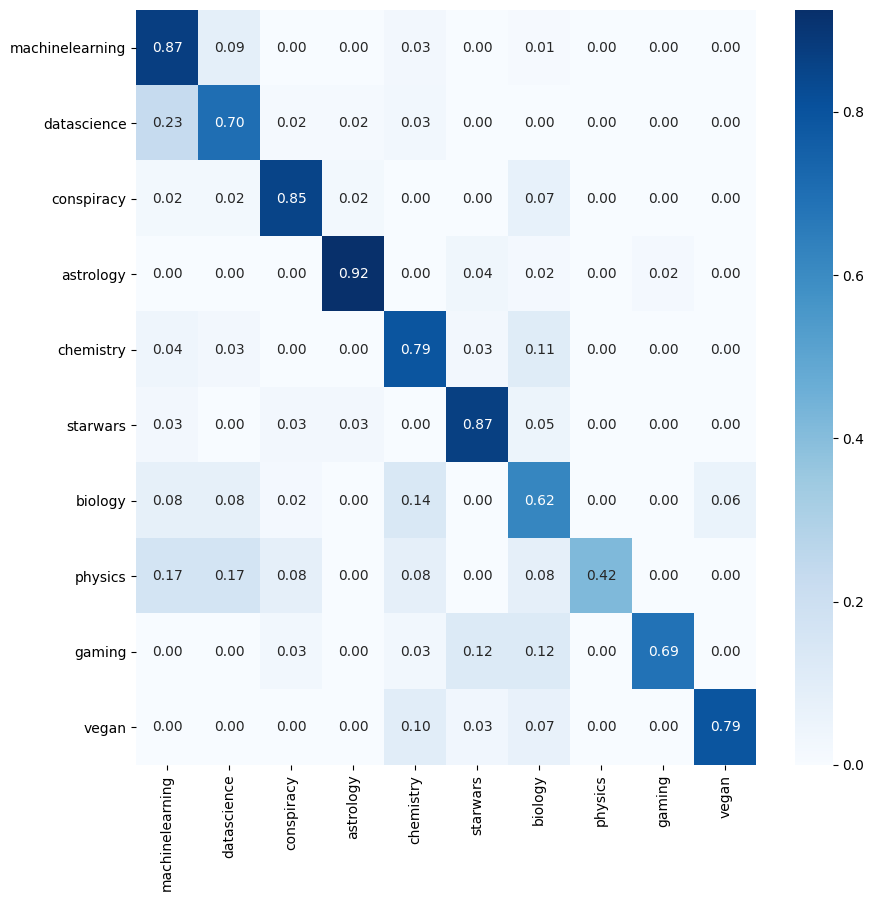

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



# Get confusion matrix
C = confusion_matrix(y_test, predictions)

# Scale feature-wise to get accuracy by forum
C_norm = C / C.sum(axis=1)[:, np.newaxis]

# Number of classes
N = len(forums)

# Plot heatmap
plt.figure(figsize=(N,N), dpi=100)
sns.heatmap(data=C_norm,
            xticklabels=forums,
            yticklabels=forums,
            annot=True, fmt='.2f',
            cmap='Blues')